In [9]:
# --- EDIT THESE ---
CSV_PATH = r"./yearly annual rainfall.csv"
ROAD_SHP  = r"./road_alignment.shp"

YEARS = list(range(2017, 2025))  # 2017–2024
GRID_RES_DEG = 0.005            # grid step in degrees (~550 m at equator; adjust)

# Fonts: Times New Roman everywhere
import matplotlib as mpl
mpl.rcParams["font.family"]   = "Times New Roman"
mpl.rcParams["axes.titlesize"] = 12
mpl.rcParams["axes.labelsize"] = 10
mpl.rcParams["xtick.labelsize"] = 8
mpl.rcParams["ytick.labelsize"] = 8
mpl.rcParams["legend.fontsize"] = 9

import os, numpy as np, pandas as pd, geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import FuncFormatter, MultipleLocator
from matplotlib_map_utils.core.north_arrow import NorthArrow, north_arrow
from matplotlib_map_utils.core.scale_bar import ScaleBar, scale_bar


In [2]:
def idw_interpolate(xy_known, values, X_grid, Y_grid, power=2.0, eps=1e-12):
    xs = xy_known[:,0][:,None,None]
    ys = xy_known[:,1][:,None,None]
    dx = X_grid[None,:,:] - xs
    dy = Y_grid[None,:,:] - ys
    dist2 = dx*dx + dy*dy + eps
    w = 1.0 / (dist2**(power/2.0))
    num = (w * values[:,None,None]).sum(axis=0)
    den = w.sum(axis=0)
    return num / den

def fmt_lon_dm(val, pos=None):
    hemi = "E" if val >= 0 else "W"
    d = int(val)
    m = int(round(abs((val - d) * 60)))   # round to nearest whole minute
    return f"{abs(d)}°{m:02d}′{hemi}"

def fmt_lat_dm(val, pos=None):
    hemi = "N" if val >= 0 else "S"
    d = int(val)
    m = int(round(abs((val - d) * 60)))   # round to nearest whole minute
    return f"{abs(d)}°{m:02d}′{hemi}"

def make_class_breaks(values, n=9):
    vals = np.asarray(values, dtype=float)
    vals = vals[np.isfinite(vals)]
    qs = np.linspace(0, 1, n+1)
    raw = np.quantile(vals, qs)
    return np.unique(np.round(raw, 0).astype(int))  # force integer breaks


In [3]:
# Load CSV
df = pd.read_csv(CSV_PATH, sep=None, engine="python")

# Try to detect columns
def pick(cols, keys):
    keys = [k.lower() for k in keys]
    for c in cols:
        cl = str(c).strip().lower()
        if cl in keys: return c
    # partial contains
    for c in cols:
        cl = str(c).strip().lower()
        if any(k in cl for k in keys): return c
    return None

x_col = pick(df.columns, ["co-ordinate(x)", "longitude", "lon", "x"])
y_col = pick(df.columns, ["co-ordinade(y)", "co-ordinate(y)", "latitude", "lat", "y"])

assert x_col and y_col, "Couldn't detect coordinate columns—set x_col/y_col manually."

gdf_wgs = gpd.GeoDataFrame(
    df.copy(),
    geometry=[Point(xy) for xy in zip(df[x_col], df[y_col])],
    crs="EPSG:4326"
)

# Roads → WGS84
roads = gpd.read_file(ROAD_SHP)
if roads.crs is None:
    roads = roads.set_crs("EPSG:4326")  # adjust if you know the true CRS
else:
    roads = roads.to_crs("EPSG:4326")

# Grid in degrees (use padded bounds)
xmin, ymin, xmax, ymax = gdf_wgs.total_bounds
pad = 0.01  # ~0.6′ padding
xs = np.arange(xmin - pad, xmax + pad + GRID_RES_DEG, GRID_RES_DEG)
ys = np.arange(ymin - pad, ymax + pad + GRID_RES_DEG, GRID_RES_DEG)
X, Y = np.meshgrid(xs, ys)


In [4]:
all_vals = []
for y in YEARS:
    col = str(y)
    if col in gdf_wgs.columns:
        all_vals.append(pd.to_numeric(gdf_wgs[col], errors="coerce").values)
all_vals = np.concatenate(all_vals)
levels_all = make_class_breaks(all_vals, n=9)

cmap = plt.get_cmap("terrain", 9)
norm = BoundaryNorm(levels_all, ncolors=cmap.N, clip=True)

# Pre-build labels centered between class bounds
cbar_ticks = [(levels_all[i] + levels_all[i+1]) / 2 for i in range(len(levels_all)-1)]
cbar_ticklabels = [f"{int(levels_all[i]):,} – {int(levels_all[i+1]):,}" for i in range(len(levels_all)-1)]


d:\My Research\GIS Python\gis_python\Lib\site-packages\matplotlib_map_utils\core\scale_bar.py:687: UserWarning: Provided CRS EPSG:4326 uses degrees. An attempt will be made at conversion, but there will be accuracy issues: it is recommended that you use a projected CRS instead.
  warnings.warn(f"Provided CRS {bar['projection']} uses degrees. An attempt will be made at conversion, but there will be accuracy issues: it is recommended that you use a projected CRS instead.")


'rainfall_8years_dm_readable.png'

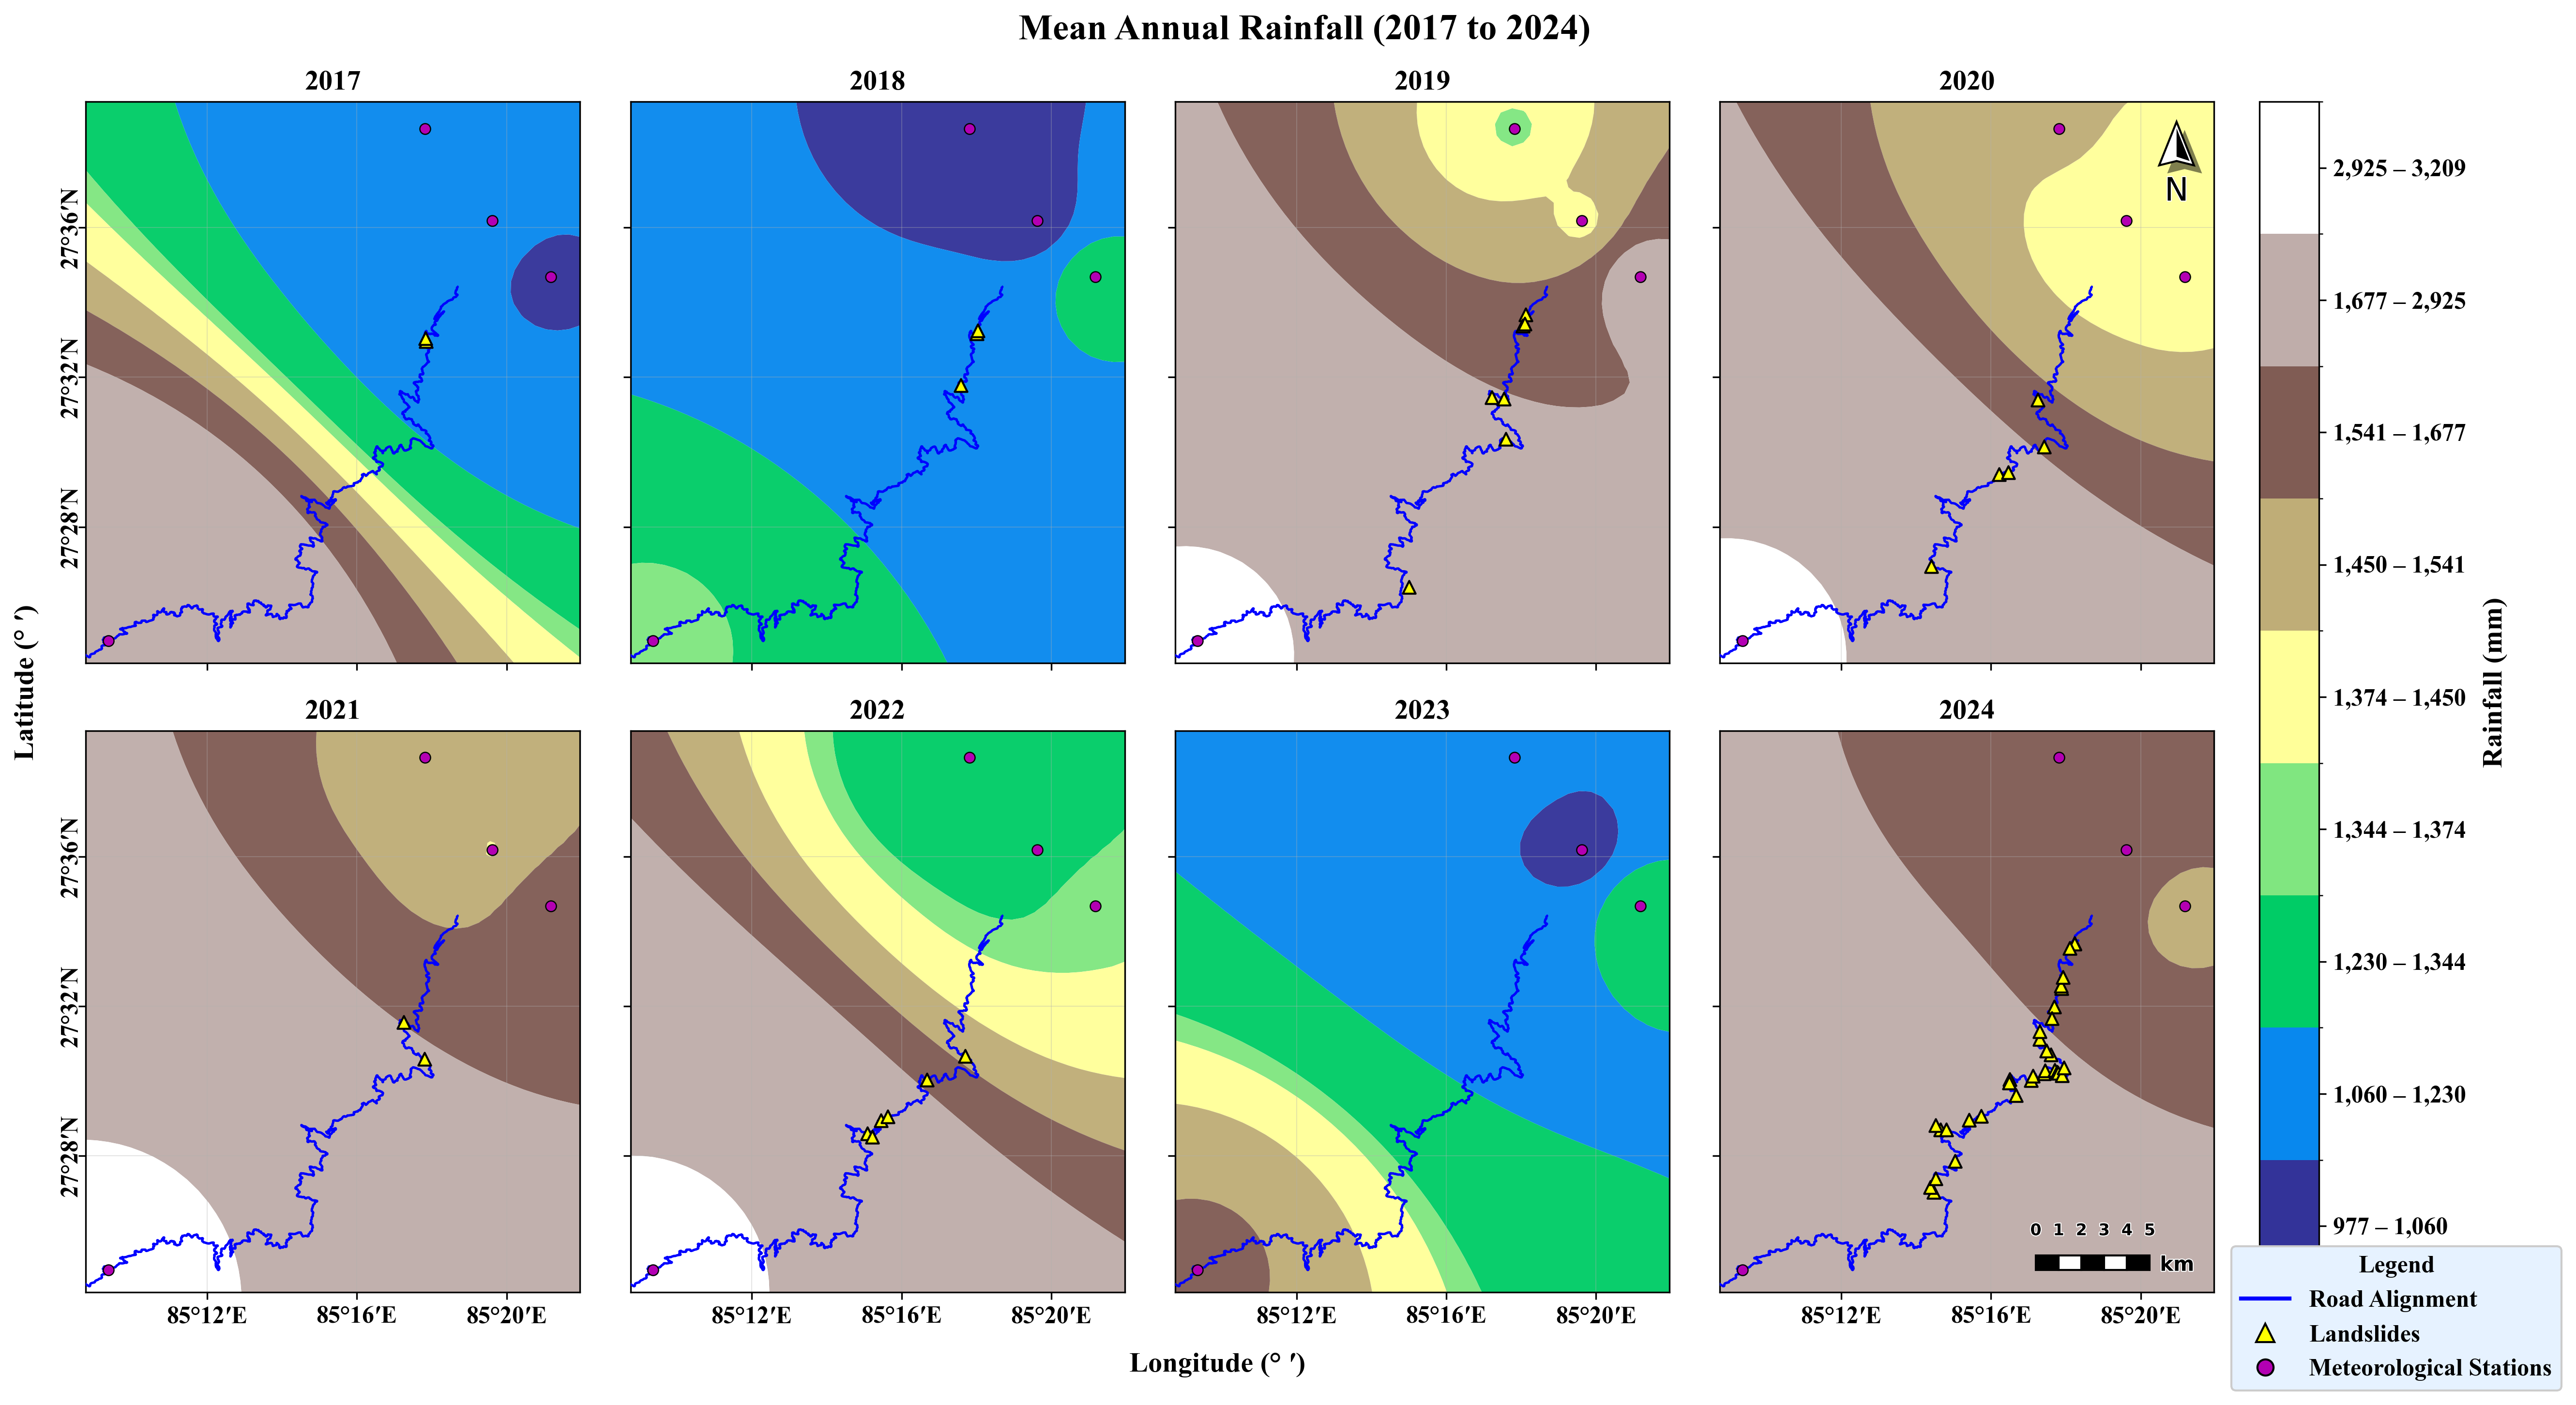

In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
from matplotlib.colors import BoundaryNorm

# --- Fonts: Times New Roman, and make tick labels a bit larger for readability
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.weight"] = "bold"
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["mathtext.default"] = "regular"  # avoid math italics if any

# --- Figure: turn OFF constrained_layout and manually reserve margins
fig, axes = plt.subplots(2, 4, figsize=(20, 10), dpi=300, constrained_layout=False)
axes = axes.ravel()

# leave space on left/bottom for global labels and on right for colorbar
fig.subplots_adjust(left=0.08, right=0.86, bottom=0.08, top=0.90, wspace=0.10, hspace=0.12)

# minute step helper (keeps 4–6 ticks typically)
def choose_minute_step(xmin, xmax, target_ticks=5):
    span_deg = abs(xmax - xmin)
    span_min = max(0.01, span_deg * 60.0)
    # nice minute steps to try
    for n in [1, 2, 3, 5, 10, 15, 20, 30]:
        if span_min / n <= target_ticks:
            return n
    return 30

x_step_min = choose_minute_step(xs.min(), xs.max(), target_ticks=5)
y_step_min = choose_minute_step(ys.min(), ys.max(), target_ticks=5)

# shared colormap / levels prepared earlier
cmap = plt.get_cmap("terrain", 9)
norm = BoundaryNorm(levels_all, ncolors=cmap.N, clip=True)
cbar_ticks = [(levels_all[i] + levels_all[i+1]) / 2 for i in range(len(levels_all)-1)]
cbar_ticklabels = [f"{int(levels_all[i]):,} – {int(levels_all[i+1]):,}" for i in range(len(levels_all)-1)]

for i, year in enumerate(YEARS):
    ax = axes[i]
    col = str(year)
    if col not in gdf_wgs.columns:
        ax.set_visible(False)
        continue
    if year!=2023:
        landslide_shapefile = gpd.read_file(f'./Results/yearly_landslide_{year}.shp')
    if year != 2023 and 'landslide_shapefile' in locals() and landslide_shapefile is not None and len(landslide_shapefile) > 0:
        landslide_shapefile.plot(
            ax=axes[i],
            color="yellow",
            edgecolor="black",
            markersize=40,
            marker="^",
            label="Landslides",
            zorder=5
        )

    # IDW on degree grid
    pts  = np.column_stack([gdf_wgs.geometry.x.values, gdf_wgs.geometry.y.values])
    vals = pd.to_numeric(gdf_wgs[col], errors="coerce").values
    Z = idw_interpolate(pts, vals, X, Y, power=2.0)

    # Surface
    cf = ax.contourf(X, Y, Z, levels=levels_all, cmap=cmap, norm=norm, alpha=0.96, antialiased=True, zorder=1)

    # Roads & stations (already in EPSG:4326)
    if len(roads) > 0:
        roads.plot(ax=ax, color="blue", linewidth=1.2, zorder=3)
    gdf_wgs.plot(ax=ax, markersize=28, color="#b300b3", edgecolor="black", linewidth=0.6, zorder=4)

    # Title
    ax.set_title(str(year), fontweight="bold")

    # Limits and aspect
    ax.set_xlim(xs.min(), xs.max()); ax.set_ylim(ys.min(), ys.max())
    ax.set_aspect("equal")

    # Degree–minute ticks (formatters + locators)
    ax.xaxis.set_major_formatter(FuncFormatter(fmt_lon_dm))
    ax.yaxis.set_major_formatter(FuncFormatter(fmt_lat_dm))
    ax.xaxis.set_major_locator(MultipleLocator(x_step_min / 45.0))
    ax.yaxis.set_major_locator(MultipleLocator(y_step_min / 45.0))
    ax.grid(True, which="major", linewidth=0.4, alpha=0.4)

    # Make y-tick labels vertical
    for label in ax.get_yticklabels():
        label.set_rotation(90)
        label.set_ha("center")
        label.set_va("center")

    # --- Only show ticks on LEFT column and BOTTOM row
    if i % 4 != 0:
        ax.tick_params(labelleft=False)
    if i < 4:
        ax.tick_params(labelbottom=False)

    ax.set_xlabel(""); ax.set_ylabel("")


    # no per-axis labels; we'll add global ones below
    ax.set_xlabel(""); ax.set_ylabel("")

    if i==3:
        north_arrow(ax, location="upper right",
        scale=0.3,
        rotation={"crs": gdf.crs, "reference": "center"})
    if i==7: 
        scale_bar( 
        ax, location="lower right", 
        style="boxes", bar={"projection": gdf_wgs.crs}, 
        units={"loc": "bar", "fontsize": 10, "fontweight": "bold"}, 
        labels={ "fontsize": 8, "fontweight": "bold" })

from matplotlib.lines import Line2D

# --- Figure-wide legend (roads, landslides, stations) ---
legend_handles = [
    Line2D([0], [0], color="blue", lw=2, label="Road Alignment"),
    Line2D([0], [0], marker="^", color="black", markerfacecolor="yellow",
           markeredgecolor="black", markersize=9, linestyle="None", label="Landslides"),
    Line2D([0], [0], marker="o", color="black", markerfacecolor="#b300b3",
           markeredgecolor="black", markersize=8, linestyle="None", label="Meteorological Stations"),
]

legend = fig.legend(
    handles=legend_handles,
    loc="upper left",
    bbox_to_anchor=(0.815, 0.12),   # adjust position
    frameon=True,
    title="Legend",
    prop={"family": "Times New Roman", "size": 12},
    title_fontsize=12,
)
legend.get_frame().set_facecolor("#e6f2ff")  # light blue
legend.get_frame().set_alpha(1.0)  # Make legend box fully opaque

# Shared colorbar on the right
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.tolist(), orientation="vertical",
                    fraction=0.04, pad=0.02)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(cbar_ticklabels, fontweight="bold")
cbar.ax.tick_params(labelsize=12)  # adjust size as needed

# Global labels (now they will have space and won't overlap)
fig.text(0.47, 0.03, "Longitude (° ′)", ha="center", va="center",
         fontsize=14, fontweight="bold", family="Times New Roman")
fig.text(0.06, 0.50, "Latitude (° ′)", ha="center", va="center",
         fontsize=14, fontweight="bold", rotation="vertical", family="Times New Roman")
fig.text(0.91, 0.50, "Rainfall (mm)", ha="center", va="center",
         fontsize=14, fontweight="bold", rotation="vertical", family="Times New Roman")
# Suptitle
fig.suptitle("Mean Annual Rainfall (2017 to 2024)",
             fontsize=18, fontweight="bold", y=0.96)

# Save
OUT_PATH = "rainfall_8years_dm_readable.png"
fig.savefig(OUT_PATH, dpi=300, bbox_inches="tight")
OUT_PATH